In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, desc

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
class_names = Base.classes.keys()

# Print the class names
for class_name in class_names:
    print(class_name)


measurement
station


In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station



In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

#measurement table
results = session.query(measurement.station, measurement.date, measurement.prcp, measurement.tobs).all()

#station table
results = session.query(station.station, station.name, station.latitude, station.longitude, station.elevation).all()




# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
recent_date = session.query(func.max(measurement.date)).scalar()

print(recent_date)

2017-08-23


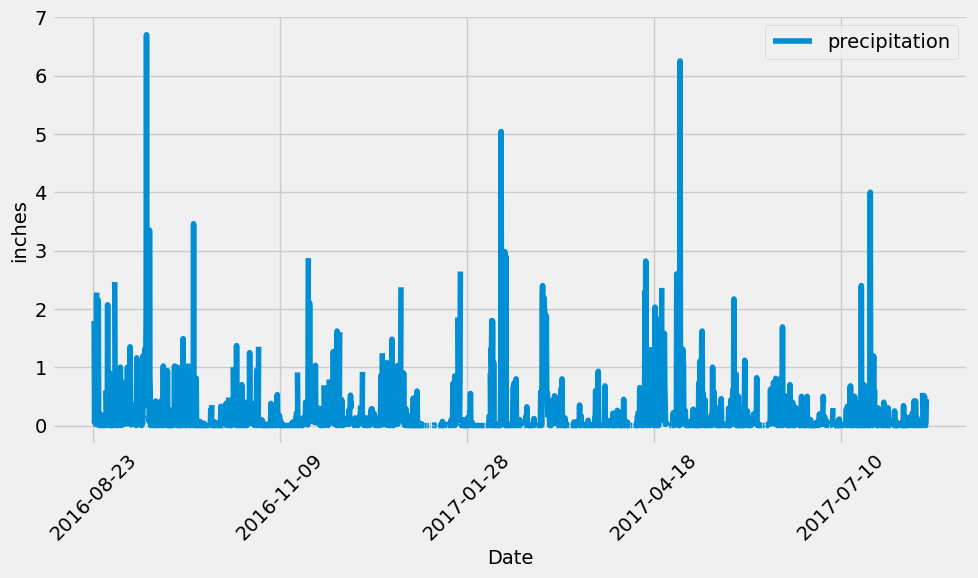

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

recent_date = session.query(func.max(measurement.date)).scalar()

#convert date and time

recent_date = dt.datetime.strptime(recent_date, '%Y-%m-%d').date()

# Calculate the date one year from the last date in data set.

one_year = recent_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores

results = session.query(measurement.date, measurement.prcp).filter(measurement.date >= one_year).all()


# Save the query results as a Pandas DataFrame. Explicitly set the column names

df = pd.DataFrame(results, columns=['date', 'precipitation'])

# Sort the dataframe by date

df_sorted = df.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data

df_sorted.plot(x='date', y='precipitation', figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('inches')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
statistics = df['precipitation'].describe()

# Add a header to the summary statistics table
statistics_header = pd.DataFrame({'precipitation': statistics})
statistics_header.index = ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']

# Print the summary statistics with the header
print(statistics_header)



       precipitation
count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
station_count = session.query(func.count(station.station)).scalar()

print(station_count)


9


In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

# Query to find the most active stations

station_counts = session.query(measurement.station, func.count(measurement.station)).\
    group_by(measurement.station).\
    order_by(desc(func.count(measurement.station))).all()

# Print the stations and their counts
for station, count in station_counts:
    print(f"Station: {station}, Count: {count}")


Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# most active station from above
active_station = station_counts[0][0]

# lowest, highest, and average temperature for the most active station
temperature_stats = session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)).\
    filter(measurement.station == active_station).all()

# Print the temperature statistics
print(f"Lowest Temperature: {temperature_stats[0][0]}")
print(f"Highest Temperature: {temperature_stats[0][1]}")
print(f"Average Temperature: {temperature_stats[0][2]}")

Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66378066378067


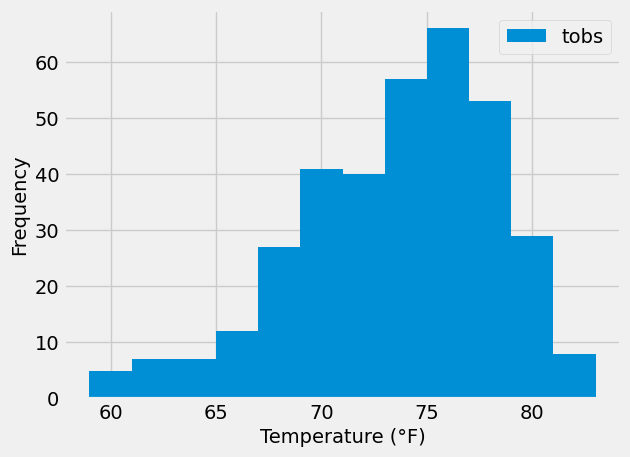

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

recent_date = session.query(func.max(measurement.date)).scalar()

#put into correct date format
recent_date = dt.datetime.strptime(recent_date, '%Y-%m-%d').date()


# Calculate the date one year ago
one_year = recent_date - dt.timedelta(days=365)

temperature_data = session.query(measurement.tobs).\
    filter(measurement.station == active_station).\
    filter(measurement.date >= one_year).all()

#list of tempatures
temperatures = [temp[0] for temp in temperature_data]

#plot histogram
plt.hist(temperatures, bins=12, label='tobs')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.legend()
plt.show()


# Close Session

In [16]:
# Close Session
session.close()